<img src="https://courses.edx.org/asset-v1:AlaskaX+SAR-401+3T2020+type@asset+block@blackboard-banner.jpg" width="100%" />

# Glacier Velocity Mapping using Template Matching

<b>Franz J Meyer, University of Alaska Fairbanks; Forrest Williams, Alaska Satellite Facility</b>

This lab will let you exercise template matching techniques for the application of glacier velocity mapping. We will initially perform template matching using cross-correlation techniques on a pair of Sentinel-2 optical images covering an are of south east Alaska that includes Malaspina and Hubbard Glaciers. Subsequently, we will work with a large number of Sentinel-1 image pairs processed using the AutoRIFT algorithm covering the same area. This larger set of images will help understand recent changes in glacier velocity at these glaciers.

<b>This notebook will introduce the following data analysis concepts</b>:

- Using template matching for the application of glacier velocity mapping
- How to order template matching-based offset maps using the AutoRIFT algorithm
- Analysis of glacier velocity changes at Maimport

<hr>

1. Importing Relevant Python Packages, Environment Setup, and Defining Helper Functions

In [1]:
%matplotlib inline
from autoRIFT import autoRIFT
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib.patches as patches
import zipfile
import pandas as pd
import time

In [2]:
# Creating target folder
path = f"{os.getcwd()}/data/sunlight_in"
if not os.path.exists(path):
    os.makedirs(path)
os.chdir(path)
print(f"Current working directory: {os.getcwd()}")

Current working directory: /home/jupyter/edc-research-demos/data/sunlight_in


In [3]:
def load_gdal(infile, band=1, subset=[0,0,None,None]):
    ds = gdal.Open(infile, gdal.GA_ReadOnly)
    
    if not band:
        data = ds.ReadAsArray(*subset)
    else:
        data = ds.GetRasterBand(band).ReadAsArray(*subset)
        
    nodata = ds.GetRasterBand(1).GetNoDataValue()
    mask = data == nodata
    data = np.ma.array(data, mask=mask, fill_value=0)
    projection = ds.GetProjection()
    transform = ds.GetGeoTransform()
    del ds
    return data, transform, projection

## 2. Introduction to the Workflow We Will Use

### 2.1 The Basic Template Matching Approach Used Here

`AutoRIFT` is a template matching python library that is used in production by the [ITS_LIVE project](https://its-live.jpl.nasa.gov) to track glacier velocities across the globe. It determines offsets at a user-specified grid spacing by comparing a square patch of pixels (a "chip") from an earlier image to the pixels in a larger square patch in a later image using an `openCV`-based **Normalized Cross Correlation** method (see figure below). The Normalized Cross Correlation analysis returns a correlation surface at integer pixel offsets between the two image chips which can be used to estimated sub-pixel offsets between the two images. These offsets are determined by finding the peak of the spline of the correlation surface in the vicinity of the highest integer correlation peak. See the image below:

<img src="https://upload.wikimedia.org/wikipedia/commons/6/6a/Convolution_of_box_signal_with_itself2.gif" width="1000" align="center">

## 2.2 Benefits of the AutoRIFT Algorithm

<img style="padding: 0px 0px 0px 10px" src="Figs/TemplateMatching.JPG" width="500" align="right" /> Because `AutoRIFT` takes `numpy` array as inputs, it can be used images of basically any format, with the caveat that the images must have the same resolution and extent. In situations where this is not case, external utilities like `GDAL` can be used to transform the input data and convert it to `numpy`. `AutoRIFT` also outputs a `numpy` array with offsets at a user-specified grid resolution in the same projection as the original images. These arrays can then be written to a variety of geospatial image formats via a external tools (i.e. `GDAl`).

`AutoRIFT` is computationally fast because of the use of `numpy` and the `openCV` library, and so can process an image pair in minutes or tens of minutes depending on the image sizes and requested grid spacing and maximum offset specified for the search. This process can be sped up by using land and ocean masks to limit search distances off of the ice and also by using reference ice flow speed maps to set search distances larger in fast flowing areas and smaller in slow flowing areas, but for simplest uses these are not applied.

## 2.3 AutoRIFT Parameters

- `Temaplate Patch Size:` The size of the template image patch that you use to perform the matching. Larger patches can typically detect smaller offsets, but with lower resolutions.

- `Step Size:` The size of the offset between template image patches, and your output resolution. If your patch size is bigger than your step, your offset measurements will not be independent.

- `Search Distance:` The size of your source image patch, and the maximum distance away from the template patch center that AutoRIFT will search for a match (can also set a minimum in AutoRIFT).

- `Oversampling:` Whether or not to use oversampling to obtain a more specific offset.

<img src="https://www.mdpi.com/remotesensing/remotesensing-13-00749/article_deploy/html/images/remotesensing-13-00749-g001.png" width="1000" align="center">

a) Template matching using normalized cross-correlation, and (b,c) the nested grid design in Autonomous Repeat Image Feature Tracking (AutoRIFT), where (b) shows the image grid and (c) shows the geographic grid. In (b,c), original chips are shown as black, dotted rectangles with the center grid point as a black dot, and chips enlarged by a factor of two (that iteratively progresses) are shown as red, dashed rectangles with the center grid point as a red dot.

Oversampling may allow you to better estimate offsets, but it will increase processing times and may lead to overly-specific results.

<img style="padding: 10px 10px 10px 10px" src="Figs/oversampling.png" width="1000" align="center" />

# 3. Exercising AutoRIFT on Galena Creek Rock Glacier

We will use a pair of Sentinel-2 images acquired in May 2020 to demonstrate how `AutoRIFT` works and which parameters it needs for creating an offset field. You can replicate this run by replacing the image pairs used below.

## 3.2 Running AutoRIFT to Perform Template Matching-based Rock Glacier Velocity Mapping 

We now will run the `AutoRIFT` algorithm to perform template matching on the image pair. The first thing we'll do is define a helper function. This function takes AutoRIFT's main processing parameters as inputs, but abstracts away some of the nitty-gritty details so that you can perform analyses quickly.

In [4]:
def prep_autorift(reference, secondary, step=32, min_patch=64, max_patch=256, min_search_distance=0, max_search_distance=64, oversample=None):
    # intizialize
    obj = autoRIFT()

    # set imagery
    obj.I1 = reference.astype(np.float32)
    obj.I2 = secondary.astype(np.float32)

    # sampling
    obj.SkipSampleX = step
    obj.SkipSampleY = step
    
    # oversampling
    if oversample:
        obj.OverSampleRatio = oversample

    # chip size
    obj.ChipSizeMinX = min_patch
    obj.ChipSizeMaxX = max_patch
    obj.ChipSize0X = float(16)
    obj.ScaleChipSizeY = int(1)

    # search Area
    obj.minSearch = min_search_distance
    obj.SearchLimitX = max_search_distance
    obj.SearchLimitY = max_search_distance

    # result grid
    m, n = reference.shape
    xVals = np.arange(obj.SkipSampleX, n - obj.SkipSampleX, obj.SkipSampleX)
    yVals = np.arange(obj.SkipSampleY, m - obj.SkipSampleY, obj.SkipSampleY)
    ncol = int(xVals.shape[0])
    nrow = int(yVals.shape[0])
    xGrid = np.repeat(np.reshape(xVals, (1, ncol)), nrow, axis=0)
    yGrid = np.repeat(np.reshape(yVals, (nrow, 1)), ncol, axis=1)
    obj.xGrid = xGrid
    obj.yGrid = yGrid

    return obj

Next we'll read in the input data and subset it to our area of interest.

In [5]:
#bounds = np.s_[1000:7500, 0:5000]
ref, tr, pr = load_gdal('gc_2020_50cm_final.tif')
#ref = ref[bounds]
sec, ts, ps = load_gdal('gc_2024_50cm_final.tif')
#sec = sec[bounds]

/opt/conda/envs/autorift/lib/python3.11/site-packages/osgeo/gdal.py:311: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(
Warning 1: PROJ: proj_create_from_database: Open of /opt/conda/envs/autorift/share/proj failed
Warning 1: The definition of projected CRS EPSG:32612 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.
Warning 1: PROJ: proj_create_from_database: Open of /opt/conda/envs/autorift/share/proj failed
Warning 1: The definition of projected CRS EPSG:32612 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIF

In [6]:
#display transform and projection information (will need this for writing autoRIFT output)
print(tr)

print(pr)

(595390.0257, 0.5, 0.0, 4945115.8829, 0.0, -0.5)
PROJCS["WGS 84 / UTM zone 12N",GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-111],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


Let's take a look at our input images.

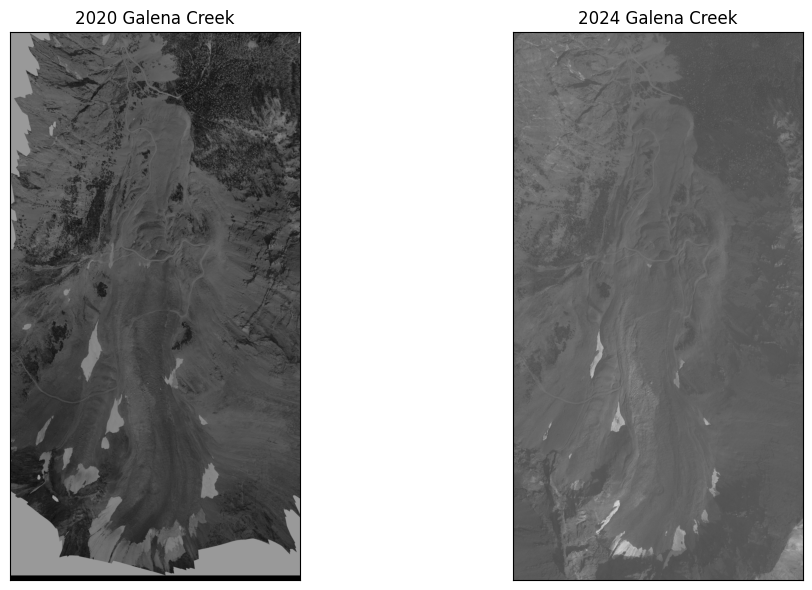

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

img_color_opts = {'vmin': 0, 'vmax': 500, 'cmap': 'Greys_r'}

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

dx_plot = ax1.imshow(ref, **img_color_opts)
ax1.set(title='2020 Galena Creek', aspect='equal', xticks=[], yticks=[])

dy_plot = ax2.imshow(sec, **img_color_opts)
ax2.set(title='2024 Galena Creek', aspect='equal', xticks=[], yticks=[])

f.tight_layout()
plt.show()

Now we'll actually run AutoRIFT. We first prep the AutoRIFT processing object, then we make sure the inputs have a uniform data type, next we filter the input data using a high-pass filter to reduce the noise in our analysis, then finally we run the template matching.

You'll see some warnings pop up when you run AutoRIFT. Don't mind those.

In [8]:
# Run autoRIFT

start_time = time.time()  # Record the start time


step = 4
result = prep_autorift(ref, sec, step=step)
result.uniform_data_type()
result.preprocess_filt_hps()
result.runAutorift()




end_time = time.time()    # Record the end time
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.4f} seconds for step=")
print(step)

# #set transform for output 
# tr_out = tr
# tr_out(1) = tr(1)*step
# tr_out(5) = tr(5)*step

#initially threw an error where the code was trying to call np.lib.pad --> needed to go into the source code and change all instances of np.lib.pad to np.pad

/opt/conda/envs/autorift/lib/python3.11/site-packages/autoRIFT/autoRIFT.py:1605: RuntimeWarning: divide by zero encountered in divide
  DxMadmin = np.ones(Dx.shape) / OverSampleRatio / SearchLimitX * 2
/opt/conda/envs/autorift/lib/python3.11/site-packages/autoRIFT/autoRIFT.py:1606: RuntimeWarning: divide by zero encountered in divide
  DyMadmin = np.ones(Dy.shape) / OverSampleRatio / SearchLimitY * 2
/opt/conda/envs/autorift/lib/python3.11/site-packages/autoRIFT/autoRIFT.py:1605: RuntimeWarning: divide by zero encountered in divide
  DxMadmin = np.ones(Dx.shape) / OverSampleRatio / SearchLimitX * 2
/opt/conda/envs/autorift/lib/python3.11/site-packages/autoRIFT/autoRIFT.py:1606: RuntimeWarning: divide by zero encountered in divide
  DyMadmin = np.ones(Dy.shape) / OverSampleRatio / SearchLimitY * 2
/opt/conda/envs/autorift/lib/python3.11/site-packages/autoRIFT/autoRIFT.py:1605: RuntimeWarning: divide by zero encountered in divide
  DxMadmin = np.ones(Dx.shape) / OverSampleRatio / SearchL

Execution time: 23.0556 seconds for step=
4


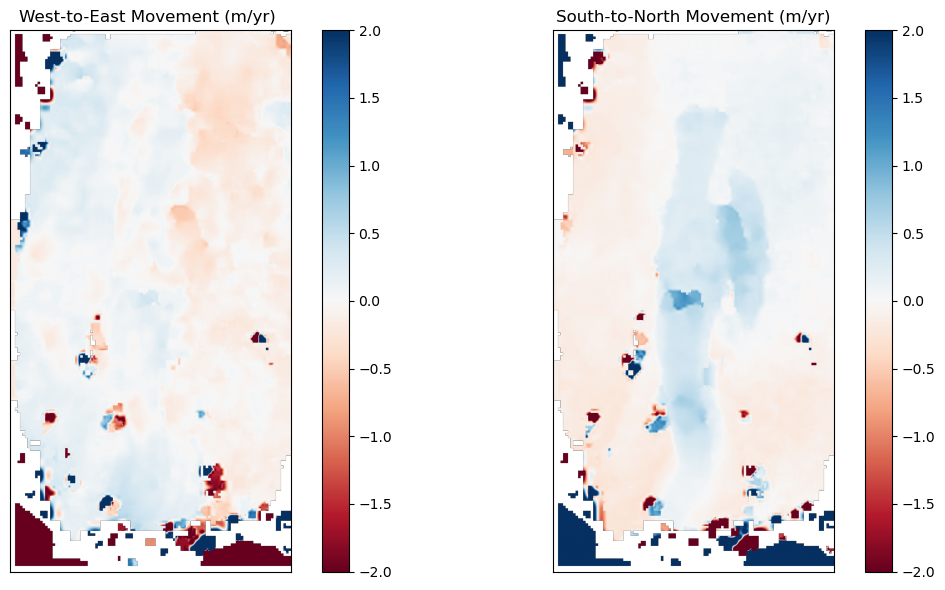

In [10]:
#plot results
%matplotlib inline
import matplotlib.pyplot as plt

px_in = 0.5 #pixel size of input (m)
interval = 4 #time interval in years

dVx = result.Dx  * px_in/interval
dVy = result.Dy  * px_in/interval

dVx_plot = dVx -0.2
dVy_plot = dVy + 0.4

vel_color_opts = {'vmin': -2, 'vmax': 2, 'cmap': 'RdBu'}

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

#removed step coefficient from plot - does result.Dx return all values in the number of ls at the input image's resolution
dx_plot = ax1.imshow(dVx_plot, **vel_color_opts)
#dx_plot = ax1.imshow(result.Dx / step, **vel_color_opts)
ax1.set(title='West-to-East Movement (m/yr) ', aspect='equal', xticks=[], yticks=[])

dy_plot = ax2.imshow(dVy_plot, **vel_color_opts)
# dy_plot = ax2.imshow(result.Dy / step, **vel_color_opts)
ax2.set(title='South-to-North Movement (m/yr)', aspect='equal', xticks=[], yticks=[])

f.colorbar(dx_plot, ax=ax1)
f.colorbar(dy_plot, ax=ax2)
f.tight_layout()
plt.show()

In [11]:
#Write data 
# Creating target folder
path_out = f"{os.getcwd()}/../galena_out/2020-2024"
if not os.path.exists(path_out):
    os.makedirs(path_out)
os.chdir(path_out)
print(f"Current working directory: {os.getcwd()}")

Current working directory: /Users/tylermeng/Documents/fieldwork/ouray2025/autorift/data/galena_out/2020-2024


In [12]:
#Write dx results
[rows, cols] = result.Dx.shape
#[rows_in, cols_in] = ref

print(rows)
print(cols)

#get upper left coordinates from projection information at geotiff import step 
# new_tr = (596954.43074913, px_in*step, 0.0, 4942254.874653916, 0.0, -px_in*step)
new_tr = (595390.0257, px_in*step, 0.0, 4945115.8829, 0.0, -px_in*step)



#Sulphur: 596954.43074913, 0.5, 0.0, 4942254.874653916, 0.0, -0.5
# Galena: 595390.0257, 0.5, 0.0, 4945115.8829, 0.0, -0.5
#for step=1, dimensions are: 12832, 7168
#step=2: 6416, 3584 - need to re export 
#step =4: 3200, 1792

864
448


In [13]:
arr_out = dVx
outFileName = "imo_dX_step4.tif"
driver = gdal.GetDriverByName("GTiff")
outdata = driver.Create(outFileName, cols, rows, 1, gdal.GDT_Float32)
outdata.SetGeoTransform(new_tr)##sets same geotransform as input
outdata.SetProjection(pr)##sets same projection as input
outdata.GetRasterBand(1).WriteArray(arr_out)
outdata.GetRasterBand(1).SetNoDataValue(10000)##if you want these values transparent
outdata.FlushCache() ##saves to disk!!
outdata = None
band=None
ds=None

In [14]:
#Write dy results
[rows, cols] = result.Dy.shape
arr_out = dVy
outFileName = "imo_dY_step4.tif"
driver = gdal.GetDriverByName("GTiff")
outdata = driver.Create(outFileName, cols, rows, 1, gdal.GDT_Float32)
outdata.SetGeoTransform(new_tr)##sets same geotransform as input
outdata.SetProjection(pr)##sets same projection as input
outdata.GetRasterBand(1).WriteArray(arr_out)
outdata.GetRasterBand(1).SetNoDataValue(10000)##if you want these values transparent
outdata.FlushCache() ##saves to disk!!
outdata = None
band=None
ds=None

In [13]:
#apply static corrections
arr_out = dVx - 0.2
outFileName = "galena_dX_step4_corrected.tif"
driver = gdal.GetDriverByName("GTiff")
outdata = driver.Create(outFileName, cols, rows, 1, gdal.GDT_Float32)
outdata.SetGeoTransform(new_tr)##sets same geotransform as input
outdata.SetProjection(pr)##sets same projection as input
outdata.GetRasterBand(1).WriteArray(arr_out)
outdata.GetRasterBand(1).SetNoDataValue(10000)##if you want these values transparent
outdata.FlushCache() ##saves to disk!!
outdata = None
band=None
ds=None

[rows, cols] = result.Dy.shape
arr_out = dVy + 0.4
outFileName = "galena_dY_step4_corrected.tif"
driver = gdal.GetDriverByName("GTiff")
outdata = driver.Create(outFileName, cols, rows, 1, gdal.GDT_Float32)
outdata.SetGeoTransform(new_tr)##sets same geotransform as input
outdata.SetProjection(pr)##sets same projection as input
outdata.GetRasterBand(1).WriteArray(arr_out)
outdata.GetRasterBand(1).SetNoDataValue(10000)##if you want these values transparent
outdata.FlushCache() ##saves to disk!!
outdata = None
band=None
ds=None

#Sulphur corrections: cx = -0.3; cy = +0.4
#Galena corrections: cx = -0.2; cy = +0.4

In [15]:
#convert to magnitude and direction 

#apply correction 
dx = dVx -0.3
dy = dVy + 0.4 
arr_out = np.sqrt(np.square(dy) + np.square(dx))
outFileName = "sunlight_20-24_magnitude.tif"
driver = gdal.GetDriverByName("GTiff")
outdata = driver.Create(outFileName, cols, rows, 1, gdal.GDT_Float32)
outdata.SetGeoTransform(new_tr)##sets same geotransform as input
outdata.SetProjection(pr)##sets same projection as input
outdata.GetRasterBand(1).WriteArray(arr_out)
outdata.GetRasterBand(1).SetNoDataValue(10000)##if you want these values transparent
outdata.FlushCache() ##saves to disk!!
outdata = None
band=None
ds=None

arr_out = (np.degrees(np.atan2(dx, dy)))
outFileName = "sunlight_20-24_bearing.tif"
driver = gdal.GetDriverByName("GTiff")
outdata = driver.Create(outFileName, cols, rows, 1, gdal.GDT_Float32)
outdata.SetGeoTransform(new_tr)##sets same geotransform as input
outdata.SetProjection(pr)##sets same projection as input
outdata.GetRasterBand(1).WriteArray(arr_out)
outdata.GetRasterBand(1).SetNoDataValue(10000)##if you want these values transparent
outdata.FlushCache() ##saves to disk!!
outdata = None
band=None
ds=None